### Imports

In [7]:
from scipy.io import wavfile
import numpy as np
import IPython
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf

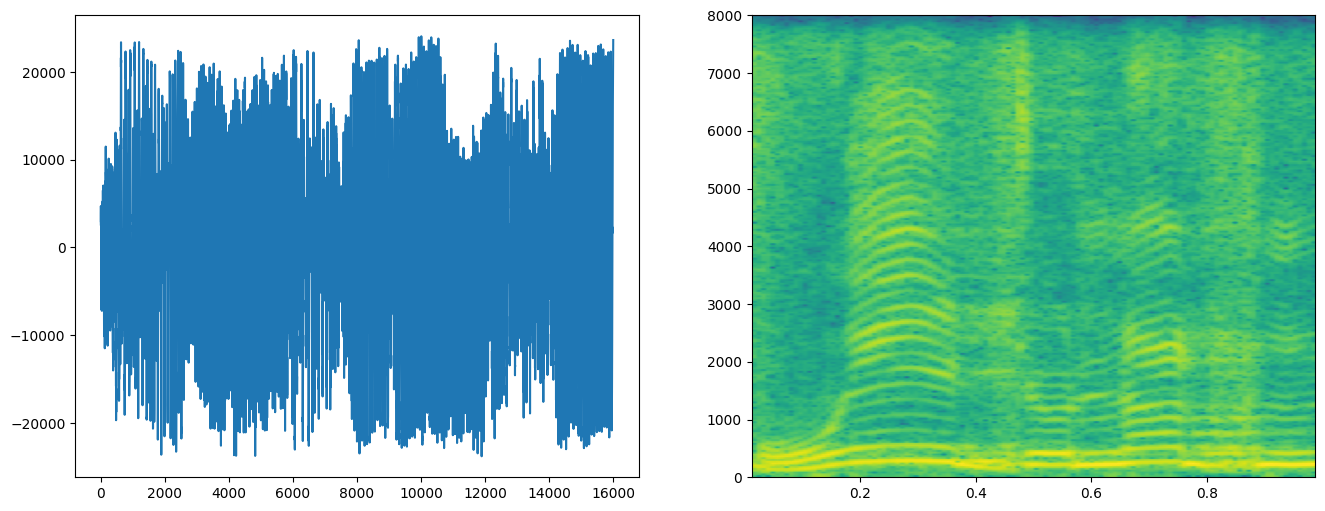

In [8]:
mandela_fs, mandela = wavfile.read("./1020.wav")


plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(mandela)
plt.subplot(122)

N = 512
plt.specgram(mandela, Fs=mandela_fs, NFFT=N, noverlap=int(3/4*N))

IPython.display.Audio(mandela, rate=mandela_fs)

### Voice activity detection

In [9]:
window_params = {
    "SAMPLE_START":  0, # the start index
    "SPEECH_START_BAND": 300, # the minimum frequency of a human voice
    "SPEECH_END_BAND": 3000, # the maximum frequency of a human voice
    "SAMPLE_WINDOW": 0.02, # a 20 ms window size on which we run the algorithm
    "SAMPLE_OVERLAP": 0.01, # the amount by which we shift the window size at each step
    "THRESHOLD": 0.6 # the threshold for the energy ratio under which a sound is not tagged as a voice
}

### Extracting cepstral coefficients

Speech Feature Extraction

function ```F_feature_extraction``` computes the cepstral parameterization associated. With regard to the parameters of the analysis, we will make the following choices:
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored as a list of vectors
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c}
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each element of the list $X_i$ represent the cepstral representation for time frame $i$, it is a vector of size $p$.
Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable.
We obtain one list of this type for each audio signal.

In [10]:
def F_feature_extraction(wav_v, window_size, window_shift, cepstral_order):
    """
    Args:
        wav_v
        window_size
        window_shift
        cepstral_order
    Outputs:
        cepstral_vectors_l: list of cesptral vectors, each element of the list is one cepstral vector, each vector is a np.array of size (cepstral_order)
    """

    cepstral_vectors_l = []   
    for i in range(0, len(wav_v) - window_size, window_shift):
        ## windowing
        hann_window = np.hanning(window_size)

        ## fft
        fft_ = wav_v[i:i+window_size] * hann_window

        fft_log = np.log(np.abs(np.fft.fft(fft_)))
        cepstral_vectors_l.append(np.fft.ifft(fft_log).real[:cepstral_order])
    

    return cepstral_vectors_l

cepstral_vectors_l = F_feature_extraction(mandela, 1024, 512, 13)

Normalizing the cepstral coefficients

### Recording my voice

In [25]:
fs = 44100  # Sample rate
seconds = 1  # Duration of recording

print("Recording...")
my_voice = sd.rec(int(seconds * fs), samplerate=fs, channels=1, dtype='int16')
sd.wait()
print("Recording done")
# saving the recording
sf.write('iliass.wav', my_voice, fs)

Recording...
Recording done


In [22]:
# feature extraction
my_voice = my_voice.flatten()
speaker_features = F_feature_extraction(my_voice, 1024, 512, 13)
speaker_features = np.array(speaker_features)

### UBM

In [14]:
ubm_params = {
    "n_components": 1,
    "n_iter": 10,
    "covariance_type": "diag",
    "random_state": 0,
    "n_init": 1,
    "tol": 0.001
}

from sklearn.mixture import GaussianMixture

gmm_ubm = GaussianMixture(n_components=ubm_params["n_components"], 
                      covariance_type=ubm_params["covariance_type"], 
                      random_state=ubm_params["random_state"], 
                      n_init=ubm_params["n_init"], 
                      tol=ubm_params["tol"])

gmm_ubm.fit(cepstral_vectors_l)

GaussianMixture(covariance_type='diag', random_state=0)

In [23]:
def map_adaptation(gmm_ubm, speaker_features, relevance_factor=16):
    """
    Maximum A Posteriori (MAP) adaptation of a GMM-UBM to a specific speaker.
    """
    # Number of components in the UBM
    n_components = gmm_ubm.n_components
    
    # Perform MAP adaptation
    adapted_means = np.copy(gmm_ubm.means_)
    adapted_covariances = np.copy(gmm_ubm.covariances_)
    adapted_weights = np.copy(gmm_ubm.weights_)
    
    # Calculate responsibilities
    responsibilities = gmm_ubm.predict_proba(speaker_features)
    n_features = speaker_features.shape[1]
    
    # Update the means using the MAP adaptation formula
    for i in range(n_components):
        # Effective number of samples assigned to component i
        N_i = np.sum(responsibilities[:, i])
        
        # Update the mean
        adapted_means[i] = (N_i * np.mean(speaker_features, axis=0) + relevance_factor * gmm_ubm.means_[i]) / (N_i + relevance_factor)
        
        # Update the covariance
        adapted_covariances[i] = (N_i * np.cov(speaker_features, rowvar=False) + relevance_factor * gmm_ubm.covariances_[i]) / (N_i + relevance_factor)
    
    # Create a new GMM for the speaker
    speaker_gmm = GaussianMixture(n_components=n_components, covariance_type='diag')
    speaker_gmm.means_ = adapted_means
    speaker_gmm.covariances_ = adapted_covariances
    speaker_gmm.weights_ = adapted_weights
    speaker_gmm.precisions_cholesky_ = np.linalg.cholesky(1.0 / adapted_covariances)
    
    return speaker_gmm

# Adapt the UBM to the specific speaker
speaker_gmm = map_adaptation(gmm_ubm, speaker_features)

ValueError: could not broadcast input array from shape (13,13) into shape (13,)

In [ ]:
def compute_log_likelihood(gmm_model, features):
    return gmm_model.score(features)

# Test speaker verification
test_file_path = 'path_to_test_audio_file.wav'
test_features = extract_mfcc(test_file_path)

# Compute log-likelihoods
ubm_score = compute_log_likelihood(gmm_ubm, test_features)
speaker_score = compute_log_likelihood(speaker_gmm, test_features)

# Decision: speaker verification
if speaker_score > ubm_score:
    print("Speaker verified.")
else:
    print("Speaker not verified.")